In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

In [2]:
# Parameters
Ny = 1024
dtype = np.float64
beta = 0.8
Wi = 80.0
epsilon = 1e-3
kappa = 5e-5

# Bases
ycoord = d3.Coordinate('y')
dist = d3.Distributor(ycoord, dtype=dtype)
basis = d3.Chebyshev(ycoord, size=Ny, bounds=(-1, 1))

# Fields
U = dist.Field(name='U', bases=basis)
a_xx = dist.Field(name='a_xx', bases=basis)
a_xy = dist.Field(name='a_xy', bases=basis)
tau_u1 = dist.Field(name='tau_u1'); tau_a_xx1 = dist.Field(name="tau_a_xx1");  tau_a_xy1 = dist.Field(name="tau_a_xy1") # z = -1
tau_u2 = dist.Field(name='tau_u2'); tau_a_xx2 = dist.Field(name="tau_a_xx2");  tau_a_xy2 = dist.Field(name="tau_a_xy2") # z = +1


# Substitutions
y = dist.local_grid(basis)

# boundary condition and hyperbolic solution of conformation tensor
A = 1/(6*beta*epsilon); B = Wi/(2*beta*epsilon)
Fm = lambda y: np.cbrt(-B*y - np.sqrt(A**3 + (B*y)**2))
Fp = lambda y: np.cbrt(-B*y + np.sqrt(A**3 + (B*y)**2))
a_xy['g'] = Fm(y) + Fp(y)
a_xx['g'] = 2*(a_xy['g'])**2 + 1
a_xy_lower = Fm(-1) + Fp(-1); a_xx_lower = 2*a_xy_lower**2 + 1
a_xy_upper = Fm( 1) + Fp( 1); a_xx_upper = 2*a_xy_upper**2 + 1

# differential operator and tau terms
dy = lambda A: d3.Differentiate(A, ycoord)
da_xy = dy(a_xy)
lift_basis = basis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

# Problem
hyperbolic_problem = d3.LBVP([U, tau_u1, tau_u2], namespace=locals())
hyperbolic_problem.add_equation("dy(dy(U)) + lift(tau_u1, -1) + lift(tau_u2, -2) = -2/beta - (1 - beta)/(beta*Wi)*da_xy")
hyperbolic_problem.add_equation("U(y=-1) = 0")
hyperbolic_problem.add_equation("U(y=1) = 0")

# Solve the hyperbolic problem for Ulam profile with kappa = 0
solver = hyperbolic_problem.build_solver()
solver.solve()

2025-04-15 18:52:32,314 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s


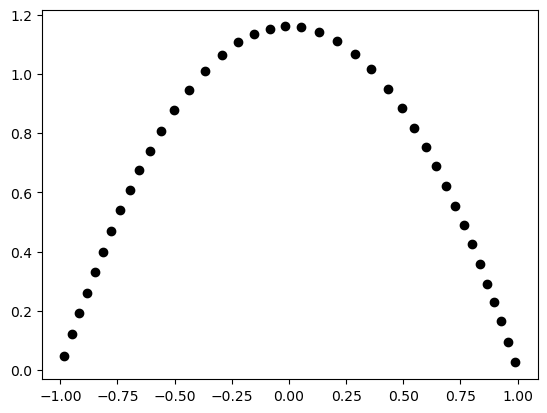

In [ ]:
data_ref = np.loadtxt('prl_2022_Morozov_Fig2b.txt')
fig, ax = plt.subplots()
ax.plot(data_ref[:, 0], data_ref[:, 1], 'ko')
U.change_scales(1)
ax.plot()